## Loading data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import json
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
conn = sqlite3.connect('sqlite.db')
df_exec = pd.read_sql_query("SELECT * FROM 'exec';", conn)

In [3]:
display(df_exec.head())

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [6]:
df_exec['rates1'] = np.nan
df_exec['rates5'] = np.nan
for it in enumerate(df_exec.rates.values):
    Dic = json.loads((it[1]))
    df_exec.set_value(it[0], 'rates1', Dic["1"])
    df_exec.set_value(it[0], 'rates5', Dic["5"])
    
df_exec = df_exec.sort_values('ts').reset_index(drop=True)    
   

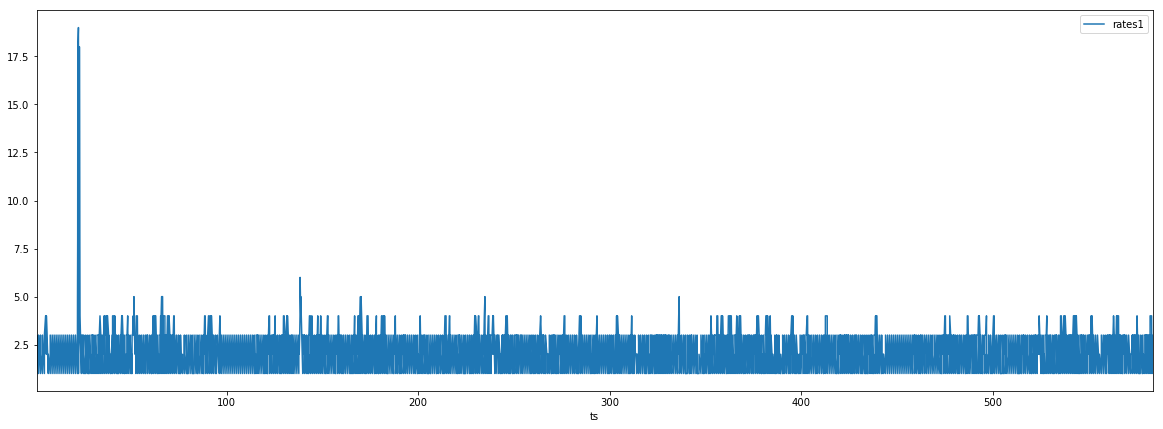

In [7]:
tm = df_exec[['ts','rates1']].set_index('ts')
tm.plot(figsize=(20,7))
plt.show()

In [8]:
conn = sqlite3.connect('sqlite.db')
df_tcplife = pd.read_sql_query("SELECT * FROM 'tcplife';", conn)

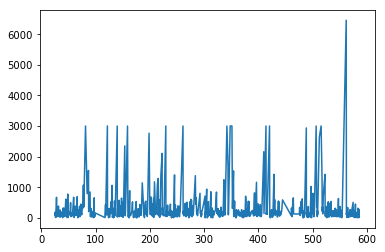

,ts,pid,rx,tx,dur,prediction,predquality
count,944.000000,944.000000,944.000000,944.0,944.000000,944.000000,944.000000
mean,307.715209,29928.452331,61.332627,0.0,261.219121,-15.492141,0.875000
std,171.971029,751.111665,69.228605,0.0,479.331879,23.434887,0.330894
min,25.147065,28668.000000,0.000000,0.0,5.040000,-569.245187,0.000000
25%,157.886505,29267.750000,4.000000,0.0,85.512500,-13.940197,1.000000
50%,307.397860,29935.500000,26.000000,0.0,144.650000,-11.497844,1.000000
75%,462.115531,30601.000000,115.000000,0.0,226.797500,-10.481379,1.000000
max,585.672974,31149.000000,540.000000,0.0,6454.020000,8.375431,1.000000


In [10]:
plt.plot(df_tcplife.ts,df_tcplife.dur)
plt.show()




df_tcplife.describe()